In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

from numpy import linalg as LA
from time import time
from pprint import pprint
from copy import deepcopy as copy


%matplotlib inline

# Functions to read data

In [2]:
def read_US_states(fname):
    states_abb_dict = {}
    states_abb_rev_dict = {}
    states_abb_ord_list = []
    with open(fname, "r") as f:
        for line in f:
            line = line.strip().split(",")
            name = line[0]
            abbr = line[1]
            states_abb_dict[name] = (abbr, len(states_abb_ord_list))
            states_abb_rev_dict[abbr] = name
            states_abb_ord_list.append(abbr)
    
    return states_abb_dict, states_abb_rev_dict, states_abb_ord_list

def read_travel_network(fname, states_abb_dict, states_abb_rev_dict, normalization=1):
    num_states = 50

    adjacency_list = {}
    A = np.zeros((num_states, num_states))

    for abb in states_abb_rev_dict:
        adjacency_list[abb] = []

    with open(fname, "r") as f:
        for idx, line in enumerate(f):
            if idx == 0:
                continue
            line = line.strip().split(",")
            orig = line[0]
            dest = line[1]
            weight = float(line[2])*10 / normalization
            if orig == dest:
                continue
            try:
                orig_abb, orig_idx = states_abb_dict[orig]
                dest_abb, dest_idx = states_abb_dict[dest]
                adjacency_list[orig_abb].append((dest_abb, weight))
                A[orig_idx][dest_idx] = weight
            except KeyError:
                pass
    
    return adjacency_list, A

def read_deaths_data(fname):
    df = pd.read_csv(fname)
    sum_df_d = df.groupby(['State', 'Year', 'Quarter'])[['DeathsFromPneumoniaAndInfluenza']].sum().T.to_dict()
    deaths_dict = {}
    for key, deaths in sum_df_d.items():
        state, year, quarter = key
        if state == "DC":
            continue
        if state not in deaths_dict:
            deaths_dict[state] = {}
        if year not in deaths_dict[state]:
            deaths_dict[state][year] = {}
        deaths_dict[state][year][quarter] = deaths["DeathsFromPneumoniaAndInfluenza"]
    return deaths_dict

def read_population_dict(fname):
    population_dict = {}
    with open(fname, "r") as f:
        for idx, line in enumerate(f):
            if idx == 0:
                continue
            line = line.strip().split(",")
            state = line[1]
            population_dict[state] = {}
            year = 2009
            for idx, pop in enumerate(line[2:]):
                population_dict[state][year + idx] = int(pop)
    return population_dict

In [3]:
class State:
    def __init__(self, pop):
        self.num_total = pop
        self.num_infected = 0
        self.num_deceased = 0
    
    def infected_fraction(self):
        return self.num_infected / self.num_total

# Function to run simulation

In [4]:
def travel_and_infect_kernel(A, states, p_transfer, verbose=False):
    N = A.shape[0]
    new_states = copy(states)
    
    infected_fraction = np.zeros((N,))
    for i in range(N):
        infected_fraction[i] = states[i].infected_fraction()
    
    touch_fraction = 1
    
    for dest_id in range(N):
        
        # Let X be number of successful infections.
        # X is Binomial(n, p_transfer) where n is number of travelers.
        # We want X >= 1 for each person at destination i.e.,
        # at least one successful infection for each person at destination.
        # So, calculate p' = P(X >= 1) = 1 - P(X = 0) = 1 - (1-p_transfer)^n.
        # p' is the probability a person at destination gets infected.
        # This reduces problem to calculate a new r.v. Y.
        # Y is Binomial(m, p'), where m is the uninfected population of destination
        
        num_immigrants = A[:, i]
        num_infected_immigrants = np.matmul(num_immigrants, infected_fraction.T)
        # in expectation:
        # num_infected_immigrants = np.sum(A[:, i]) * p_inf
        ccdf = 1 - (1 - p_transfer)**num_infected_immigrants
        dest = states[dest_id]
        if dest.num_total - dest.num_infected > 0:
            if np.isnan(ccdf):
                ccdf = 1
            new_states[dest_id].num_infected += np.random.binomial(
                touch_fraction*(dest.num_total - dest.num_infected), ccdf)
#             # in expectation:
#             new_states[dest_id].num_infected += (dest.num_total - dest.num_infected) * ccdf
        
    return new_states

def recover_kernel(states, SIR_params):
    SIR_params = np.abs(SIR_params) / np.sum(np.abs(SIR_params))
    for i, state in enumerate(states):
        x = np.random.multinomial(states[i].num_infected, SIR_params)
        recovered = x[0]
        dead = x[2]
        state.num_total = max(state.num_total - dead, 0)
        states[i].num_infected -= (dead + recovered)
        states[i].num_deceased += dead
    return states

def local_infection_kernel(states, p_transfer):
    touch_fraction = 1
    for i, state in enumerate(states):
        states[i].num_infected = np.random.binomial(touch_fraction*(state.num_total - state.num_infected), p_transfer)
    return states

def remove_deceased_kernel(states):
    num_deceased = []
    for i, state in enumerate(states):
        num_deceased.append(state.num_deceased)
        state.num_deceased = 0
        states[i] = state
    return states, num_deceased
    
def inject_population_kernel(states, new_population):
    # new_population is somehow ordered
    for i, state in enumerate(states):
        current_pop = state.num_total
        nextgen_pop = new_population[i]
        extra_peeps = nextgen_pop - current_pop
        if extra_peeps > 0:
            state.num_total += extra_peeps
        elif extra_peeps < 0:
            # population actually decreased... remove infected and susceptible at same rate
            extra_peeps = -extra_peeps
            if extra_peeps // 2 >= state.num_infected:
                state.num_total = state.num_total - (extra_peeps - state.num_infected)
                state.num_infected = 0
            else:
                state.num_infected -= (extra_peeps - extra_peeps//2)
                state.num_total -= extra_peeps
        states[i] = state
    return states

def random_infection_kernel(states, p_inf):
    for i, state in enumerate(states):
        if state.num_total < state.num_infected:
            continue
        infected = np.random.binomial(state.num_total - state.num_infected, p_inf)
        state.num_infected += infected
        states[i] = state
    return states

# Get real data

In [6]:
data_dir = "../Data/Clean/"
deaths_fname = "deaths_NCHS_processed.csv"
population_fname = "population.csv"

states_abb_dict, states_abb_rev_dict, stats_abb_ord_list = read_US_states(data_dir + "states_abb.csv")
deaths_dict = read_deaths_data(data_dir + deaths_fname)
population_dict = read_population_dict(data_dir + population_fname)


adj_list = {}
A = {}
A[2009] = {}
A[2009][4] = read_travel_network(data_dir + "2009_Q4.csv", states_abb_dict, states_abb_rev_dict)[1]
for year in range(2010, 2019):
    A[year] = {}
    for quarter in range(1, 5):
        network_fname = str(year) + "_Q" + str(quarter) + ".csv"
        A[year][quarter] = read_travel_network(data_dir + network_fname, states_abb_dict, states_abb_rev_dict)[1]
A[2019] = {}
A[2019][1] = read_travel_network(data_dir + "2019_Q1.csv", states_abb_dict, states_abb_rev_dict)[1]

all_population = {}
years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
for year in years:
    all_population[year] = []


for state,data in population_dict.items():
    for year, pop in data.items():
        all_population[year].append(pop)
        if year == 2018:
            all_population[2019].append(pop)
        
A_dict = A

deaths_matrix = {-1: [], 1: [], 2: [], 3: [], 4:[]}
for state, yearly_deaths_dict in deaths_dict.items():
    deaths_vector = {}
    for q in deaths_matrix:
        deaths_vector[q] = []
    for year, quarterly_deaths_dict in yearly_deaths_dict.items():
        for quarter, deaths_count in quarterly_deaths_dict.items():
            deaths_vector[-1].append(deaths_count)
            deaths_vector[quarter].append(deaths_count)
    for q in deaths_matrix:
        deaths_matrix[q].append(deaths_vector[q])
        
for q in deaths_matrix:
    deaths_matrix[q] = np.array(deaths_matrix[q])
    print(deaths_matrix[q].shape)

(50, 38)
(50, 10)
(50, 9)
(50, 9)
(50, 10)


# Run quarterly simulation

In [7]:
def run_full_simulation(x, A_dict, all_population, error=False, sim_quarter=-1):
    p_inf = x[0]
    p_transfer = x[1]
    if p_inf < 0 or p_inf > 1 or p_transfer < 0 or p_transfer > 1:
        return 10
    p_rec = x[2]
    p_die = 7.540044190323758e-05
    p_stay = 1 - p_rec - p_die
    SIR = [p_rec, p_stay, p_die]
    states = []
    year_0 = 2009
    for state_id in range(50):
        state = State(all_population[year_0][state_id])
        state.num_infected += np.random.binomial(state.num_total, p_inf)
        states.append(state)

    # Propagate infection
    num_deceased = {}

    # For each year:
    for year in years:
        num_deceased[year] = {}
        # For each quarter:
        for quarter in range(1, 5):
            if year == 2009 and quarter != 4:
                continue
            if year == 2019 and quarter != 1:
                continue
            if sim_quarter != -1 and quarter != sim_quarter:
                continue
            # 1. travel and infect
            # 2. Recover
            # 3. Remove deceased and store it
            # 4. Randomly infect
            
            # add sinusoidal element to probability of infection
            p_i = p_inf*(0.25*np.cos((np.pi/2)*quarter)+0.75)
            p_t = p_transfer*(0.25*np.cos((np.pi/2)*quarter)+0.75)
            
            states = travel_and_infect_kernel(A_dict[year][quarter], states, p_t)
            states = recover_kernel(states, SIR)
            
            for i in range(8):
                states = local_infection_kernel(states, p_t)
                states = recover_kernel(states, SIR)
            
            states, dead_peeps = remove_deceased_kernel(states)
            num_deceased[year][quarter] = dead_peeps
            states = random_infection_kernel(states, p_i)

        # Inject population
        try:
            pop_vec = inject_population_kernel(states, all_population[year+1])
        except KeyError:
            # We are at the end of our data
            pass
    
    sim_deaths_matrix = []

    for year, quarterly_deaths in num_deceased.items():
        for quarter, deaths_vector in quarterly_deaths.items():
            sim_deaths_matrix.append(deaths_vector)

    sim_deaths_matrix = np.array(sim_deaths_matrix).T
    
    if error:
        return LA.norm(deaths_matrix[sim_quarter] - sim_deaths_matrix, ord='fro') / LA.norm(deaths_matrix[sim_quarter], ord='fro')
    else:
        return sim_deaths_matrix

# Minimize error to find best parameters

In [8]:
def perturbe(x, mu=0, sigma=1e-4):
    return x + np.random.normal(mu, sigma, size=x.shape)

def isvalid(x):
    return (x <= 1).all() and (x >= 0).all()

error_tol = 0.5
quarter = -1
x_best = np.array([0.1, 0.1, 0.99])

print(x_best)
error = run_full_simulation(x_best, A_dict, all_population, True, sim_quarter=quarter)
print("0", error)
error_best = error

ctr = 0
invalid_ctr = 0

while error > error_tol:
    x_i = perturbe(x_best, mu=0, sigma=1e-1)
    if not isvalid(x_i):
        invalid_ctr += 1
        if invalid_ctr % 10 == 0:
            print("Invalid: ", invalid_ctr)
        continue
    error = run_full_simulation(x_i, A_dict, all_population, True, sim_quarter=quarter)
    ctr += 1
    if error < error_best:
        x_best = copy(x_i)
        error_best = error
        print(ctr, error)
    elif ctr % 10 == 0:
        print("Counter: ", ctr)

[0.1  0.1  0.99]
0 0.5833010819375771
10 0.5824547445330325
Invalid:  10
18 0.5824100513642071
Invalid:  20
Invalid:  30
Counter:  20
Invalid:  40
30 0.5819460528144669
Invalid:  50
Invalid:  60
Counter:  40
Invalid:  70
Invalid:  80
Counter:  50
Counter:  60
Invalid:  90
Invalid:  100


KeyboardInterrupt: 

# Get simulated number of deaths for each quarter and each state

In [12]:
# print(x_best)
# sim_deaths = run_full_simulation(np.array([0.1, 0.1, 0.99]), A_dict, all_population, sim_quarter=quarter)
sim_deaths_best = run_full_simulation(np.array(x_best), A_dict, all_population, sim_quarter=quarter)

# Plot a couple of states

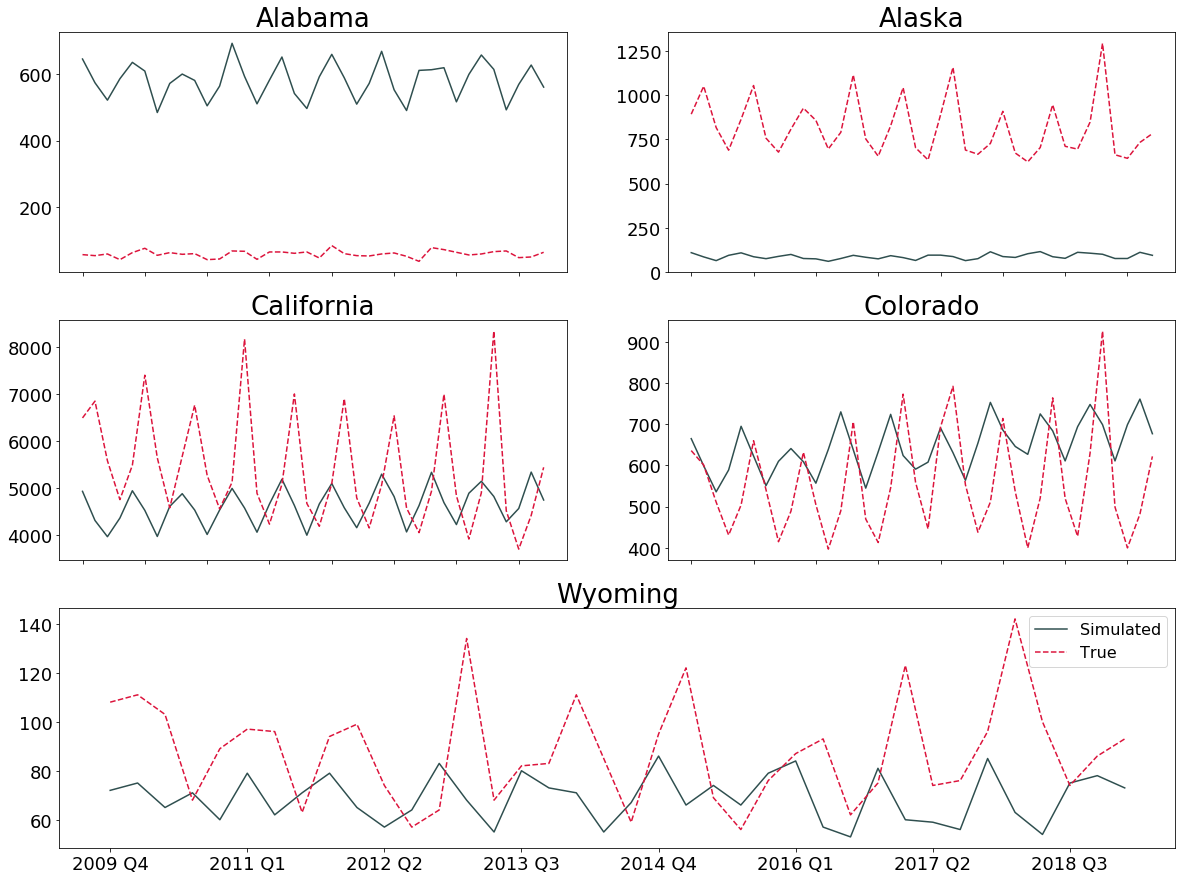

In [72]:
plt.rcParams['figure.figsize'] = [20, 15]

fig = plt.figure()

ax1 = plt.subplot2grid((3, 2), (0, 0), rowspan=1,colspan=1,)
ax2 = plt.subplot2grid((3, 2), (0, 1), rowspan=1, colspan=1,)
ax3 = plt.subplot2grid((3, 2), (1, 0), rowspan=1, colspan=1,)
ax4 = plt.subplot2grid((3, 2), (1, 1), rowspan=1, colspan=1,)
# ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=1,)
ax6 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2,)

ax1.plot(range(38), sim_deaths_best[0], color='darkslategrey')
ax1.plot(range(38), deaths_matrix[-1][0], '--', color = 'crimson')
ax1.set_title('Alabama', fontsize = 26)
ax1.set_xticklabels([])
ax1.tick_params(labelsize=18)

ax2.plot(range(38), sim_deaths_best[1], color='darkslategrey')
ax2.plot(range(38), deaths_matrix[-1][1], '--', color = 'crimson')
ax2.set_title('Alaska', fontsize = 26)
ax2.set_xticklabels([])
ax2.tick_params(labelsize=18)

ax3.plot(range(38), sim_deaths_best[4], color='darkslategrey')
ax3.plot(range(38), deaths_matrix[-1][4], '--', color = 'crimson')
ax3.set_title('California', fontsize = 26)
ax3.set_xticklabels([])
ax3.tick_params(labelsize=18)

ax4.plot(range(38), sim_deaths_best[5], color='darkslategrey')
ax4.plot(range(38), deaths_matrix[-1][5], '--', color = 'crimson')
ax4.set_title('Colorado', fontsize = 26)
ax4.set_xticklabels([])
ax4.tick_params(labelsize=18)

# ax5.plot(range(38), sim_deaths_best[33])
# ax5.plot(range(38), deaths_matrix[-1][33])
# ax5.set_title('North Dakota', fontsize = 26)
# ax5.tick_params(labelsize=18)

ax6.plot(range(38), sim_deaths_best[49], color='darkslategrey')
ax6.plot(range(38), deaths_matrix[-1][49], '--', color = 'crimson')
ax6.set_title('Wyoming', fontsize = 26)
ax6.tick_params(labelsize=18)
ax6.legend(['Simulated', 'True'], fontsize = 16)
tix = ax6.set_xticklabels([ '0', '2009 Q4', #'2010 Q1', '2010 Q2', '2010 Q3', '2010 Q4',
                     '2011 Q1', #'2011 Q2', '2011 Q3', '2011 Q4', '2012 Q1',
                     '2012 Q2', #'2012 Q3', '2012 Q4', '2013 Q1', '2013 Q2',
                     '2013 Q3', #'2013 Q4', '2014 Q1', '2014 Q2', '2014 Q3',
                     '2014 Q4', #'2015 Q1', '2015 Q2', '2015 Q3', '2015 Q4',
                     '2016 Q1', #'2016 Q2', '2016 Q3', '2016 Q4', '2017 Q1',
                     '2017 Q2', #'2017 Q3', '2017 Q4', '2018 Q1', '2018 Q2',
                     '2018 Q3']#, '2018 Q4', '2019 Q1']
                    )
# fig.text(0.05, 0.5, 'Number of deaths', va='center', rotation='vertical', fontsize=24)
# fig.text(0.5, 0.05, 'common X', ha='center')

# Bar plot of number of deaths

Text(0.5, 1.0, 'Total number of deaths per quarter')

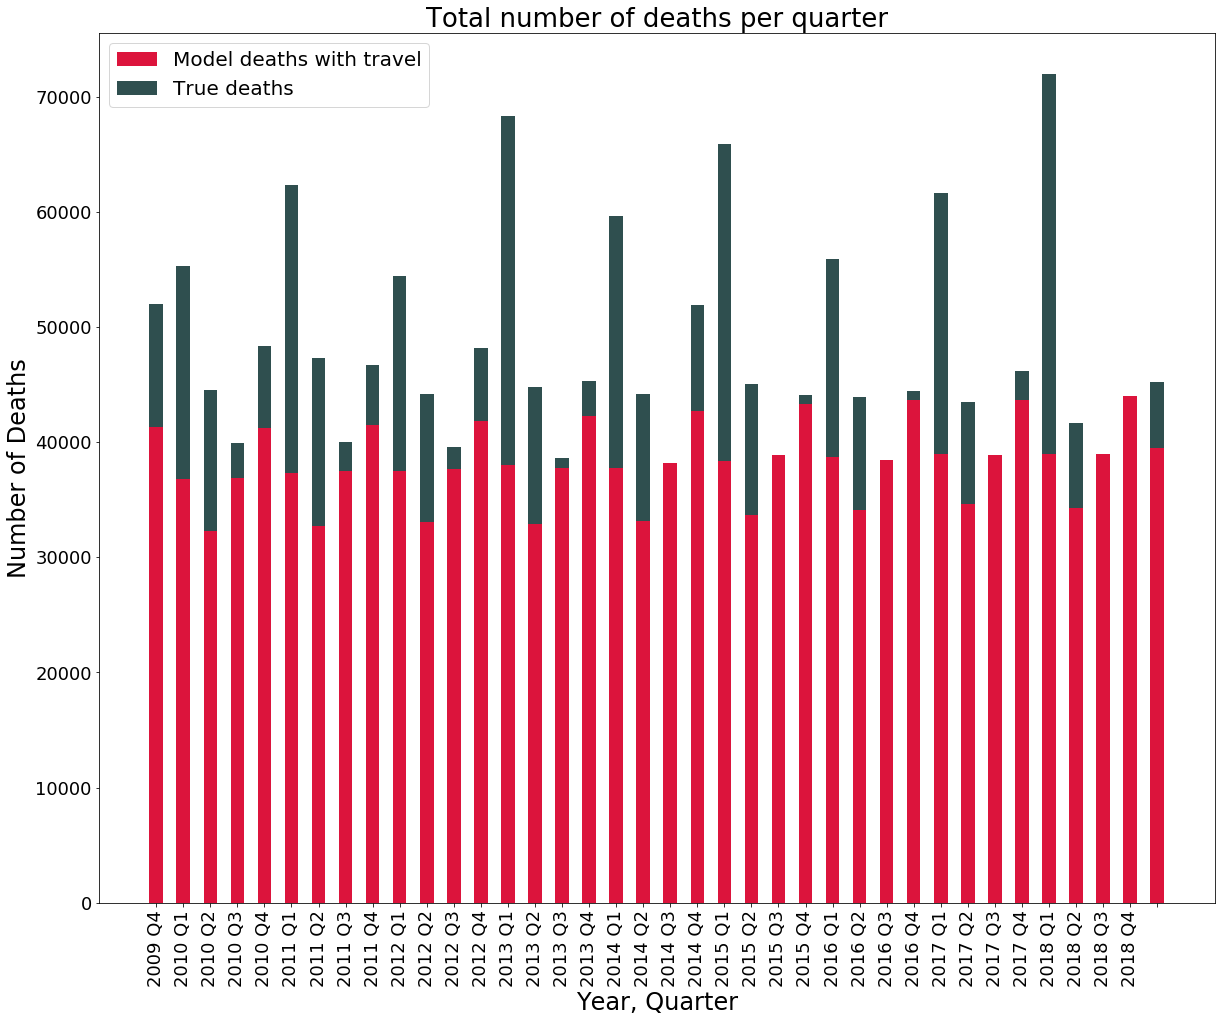

In [98]:
plt.figure(figsize=[20,16])
ind = np.arange(38)
width = 0.5

ax = plt.subplot(111)
p2 = ax.bar(ind, deaths_matrix[-1].sum(axis=0).tolist(), width, color = 'darkslategrey')
p1 = ax.bar(ind, sim_deaths_best.sum(axis=0).tolist(), width, color='crimson')
# p2 = ax.bar(ind, deaths_matrix[-1].sum(axis=0).tolist(), width,)

plt.xticks(ind, ('2009 Q4',
                '2010 Q1', '2010 Q2', '2010 Q3', '2010 Q4',
                '2011 Q1', '2011 Q2', '2011 Q3', '2011 Q4',
                '2012 Q1', '2012 Q2', '2012 Q3', '2012 Q4',
                '2013 Q1', '2013 Q2', '2013 Q3', '2013 Q4',
                '2014 Q1', '2014 Q2', '2014 Q3', '2014 Q4',
                '2015 Q1', '2015 Q2', '2015 Q3', '2015 Q4',
                '2016 Q1', '2016 Q2', '2016 Q3', '2016 Q4',
                '2017 Q1', '2017 Q2', '2017 Q3', '2017 Q4',
                '2018 Q1', '2018 Q2', '2018 Q3', '2018 Q4'), rotation=90)
# ax.autoscale(tight=True)
# plt.yticks(np.arange(0, 81, 10))
# plt.xticks(rotation=70)
plt.legend((p1[0], p2[0]), ('Model deaths with travel', 'True deaths'), fontsize='20')
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel("Year, Quarter", fontsize=24)
plt.ylabel("Number of Deaths", fontsize=24)
plt.title("Total number of deaths per quarter", fontsize=26)